<h1>Background</h1>


In this project I chose to deal with two things that are very interesting to me - medicine and music.
I found a study that deals with Neurodevelopment disorder and music. The study was conducted at Nai Disha School, Tamana NGO, New Delhi, India.

The researchers collected electron-phonographic (EEG) data from 14 participants, including 7 participants with intellectual and developmental disorder (IDD) and 7 participants without any disruption at all (TDC) under rest and under music stimuli.


The data set is unique because it stores EEG data of IDD participants who listened to music stimuli.
With these data it is possible to develop programs for the improvement and cognitive rehabilitation of the IDD population and early detection of mental disorders.

Article : https://www.biorxiv.org/content/biorxiv/early/2019/09/08/759738.full.pdf


Data : https://data.mendeley.com/datasets/fshy54ypyh/2


<h1>Import Libraries</h1>

In [1]:
from __future__ import print_function
import time

import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(1234)
from functools import reduce
import math as m
import re


import scipy.io
from scipy.interpolate import griddata
import scipy.stats as scs

from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import KFold,LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report,accuracy_score,f1_score


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Activation, LSTM, GRU, Dense, Conv1D,\
        MaxPooling1D, GlobalAveragePooling1D, Dropout, Flatten,\
        SimpleRNN, PReLU, BatchNormalization, Conv2D,\
        Conv2DTranspose, MaxPooling2D, GaussianNoise
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN,\
        ReduceLROnPlateau, CSVLogger, ModelCheckpoint

import lasagne
from tensorflow.keras.layers import InputLayer
import tensorflow as tf


import socket
import tqdm
import pywt

Using TensorFlow backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\shirg\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<h2>Deep Learning models:</h2>

<h4>Data Preprocessing:</h4>

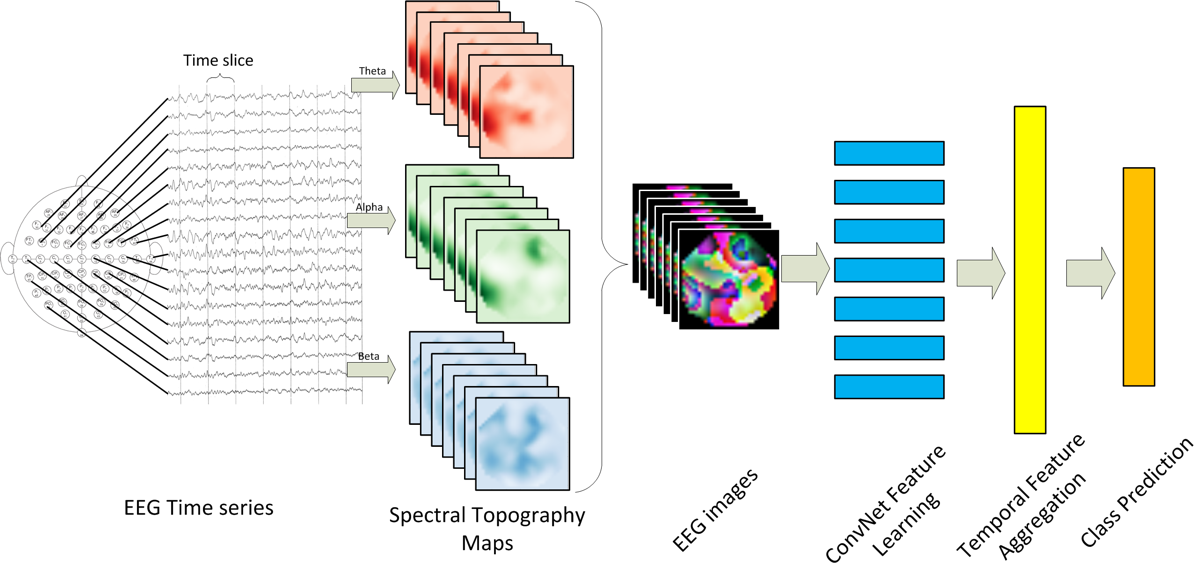

In [2]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector
    y = snippet
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    return frq,abs(Y)

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds
    overlap - float fraction of frame to overlap in range (0,1)

    out: list of tuple ranges
    '''
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])

        frames.append(frame)
    print(np.array(frames))
    return np.array(frames)



def make_data_pipeline(file_names,labels,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        X_1 = X_0.reshape(len(X_0),14*3)
        images = np.swapaxes(X_1, 1, 1) 
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

<h3>Importing Images:</h3>

In [3]:
train_file_names = ['DataForCnn/Train/IDD/clean_data1.csv',
                    'DataForCnn/Train/IDD/clean_data2.csv',
                    'DataForCnn/Train/IDD/3.csv',
                    'DataForCnn/Train/IDD/clean_data4.csv',
                    'DataForCnn/Train/IDD/clean_data5.csv',
                    'DataForCnn/Train/IDD/clean_data7.csv',
                    'DataForCnn/Train/TDC/clean_data1.csv',
                    'DataForCnn/Train/TDC/clean_data3.csv',
                    'DataForCnn/Train/TDC/clean_data4.csv',
                    'DataForCnn/Train/TDC/clean_data5.csv',
                    'DataForCnn/Train/TDC/clean_data6.csv',
                    'DataForCnn/Train/TDC/clean_data7.csv']

test_file_names = ['DataForCnn/Test/clean_data6.csv',
                   'DataForCnn/Test/clean_data2.csv']

train_labels = [0,0,0,0,0,0,1,1,1,1,1,1]

#############These labels are backwards###############
test_labels = [0,1]
###################################################################################

frame_duration = 1.0
overlap = 0.75
x_train, y_train = make_data_pipeline(train_file_names,train_labels,frame_duration,overlap)
x_test, y_test = make_data_pipeline(test_file_names,test_labels,frame_duration,overlap)


x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

Generating training data...
Processing session:  DataForCnn/Train/IDD/clean_data1.csv . ( 1  of  12 )
[[[1.37584322 1.73802783 0.61060832]
  [1.09447673 1.57733571 0.76328528]
  [1.32881515 0.89866981 0.42848246]
  ...
  [1.00244748 1.741599   0.63258027]
  [1.28642755 1.24944194 0.56773062]
  [1.21284917 2.16655397 0.60138017]]

 [[1.0644785  1.74630121 0.60654322]
  [1.09972787 1.61730743 0.81103488]
  [1.03969987 0.93833402 0.49783349]
  ...
  [0.70879972 1.73867066 0.62918905]
  [0.88113823 1.34745019 0.68517704]
  [0.93579063 2.13679776 0.71465484]]

 [[1.08592328 1.90082814 0.59024835]
  [0.87953119 1.63988752 0.73996518]
  [1.2054656  1.0934485  0.52554218]
  ...
  [0.79066894 1.68317291 0.57845062]
  [1.24092292 1.55737992 0.57512817]
  [1.28309896 2.24200742 0.73312607]]

 ...

 [[1.11152609 1.93232337 0.43539501]
  [0.70631534 1.57759787 0.49555226]
  [0.75219448 0.76398979 0.23323487]
  ...
  [0.90599013 1.64452994 0.31640141]
  [1.00422279 1.34299539 0.59714578]
  [1.241374

  [1.59711076 1.55242779 0.34133105]]]
Processing session:  DataForCnn/Train/TDC/clean_data1.csv . ( 7  of  12 )
[[[1.24157613 1.94040836 0.46418105]
  [1.36884469 1.64816772 0.43140415]
  [1.12949027 1.68502875 0.44163535]
  ...
  [1.10911811 1.51489145 0.37721353]
  [1.24634864 1.02692887 0.53000914]
  [0.9513058  1.20075737 0.42476456]]

 [[1.59118481 1.90545466 0.58676628]
  [1.2936953  1.37107019 0.4482095 ]
  [1.12805849 1.83052782 0.48483148]
  ...
  [1.27687158 1.66151657 0.37590197]
  [0.84916698 0.93026639 0.45381962]
  [1.16737328 1.20378444 0.43973781]]

 [[1.30317457 2.06020979 0.5273222 ]
  [1.47259469 1.55263762 0.42100344]
  [1.27512939 2.0649045  0.41625847]
  ...
  [1.19691917 1.78566993 0.36547549]
  [0.88349143 0.75536917 0.47312806]
  [0.96572232 1.32601714 0.43475468]]

 ...

 [[1.78930103 0.78005908 0.49230836]
  [1.3297227  0.76804485 0.52726809]
  [1.87192986 0.40357106 0.4188502 ]
  ...
  [2.0160002  0.62112581 0.39037588]
  [2.238618   0.90817174 0.62899556]


  [2.35169291 1.33775393 0.36610228]]]
Generating training data...
Processing session:  DataForCnn/Test/clean_data6.csv . ( 1  of  2 )
[[[4.05906372 2.17122708 0.91466541]
  [4.82014872 2.04537955 0.84677876]
  [3.24526648 1.57400554 0.73965696]
  ...
  [3.88680073 2.39302897 0.8619369 ]
  [4.3352565  2.48361721 1.05825959]
  [4.15687573 3.16616663 0.75362565]]

 [[4.77756523 2.55683684 0.84735265]
  [3.98065779 2.07489994 0.7886874 ]
  [2.68428852 2.12020599 0.788835  ]
  ...
  [3.2412519  2.35841178 0.79344612]
  [3.45875722 2.73250288 1.02735981]
  [4.58140154 3.08553474 0.7609985 ]]

 [[3.29713307 2.50017    0.88143747]
  [3.91614962 2.55771185 0.81821255]
  [2.68266297 2.01036588 0.88523707]
  ...
  [3.66517702 2.56798095 0.82570664]
  [2.3993134  2.99139534 1.01395187]
  [3.8430433  3.05050595 0.81275293]]

 ...

 [[2.87258486 3.25842641 1.06016077]
  [4.78806755 3.94248444 1.08197586]
  [3.69169456 2.58928445 0.79656647]
  ...
  [3.44638904 1.99246702 1.10244959]
  [2.90810749 2

In [4]:
x_train.shape
Xi_train = np.reshape(x_train, (x_train.shape[0],14,3))
Xi_test = np.reshape(x_test, (x_test.shape[0],14,3))


batch_size = 128
num_classes = 2
epochs = 100

<h4>LSTM</h4>

In [5]:
def LSTM_M(Xi_train, y_train,Xi_test, y_test):
    model = Sequential()
    model.add(LSTM(10, input_shape=(14, 3), return_sequences=True, implementation=2))
    model.add(Dense(1))
    model.add(MaxPooling1D(3))

    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0011, decay=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    history = model.fit(Xi_train, y_train, epochs=25, batch_size=batch_size, verbose=1, validation_data=(Xi_test, y_test))
    score = model.evaluate(Xi_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [6]:
LSTM_M(Xi_train, y_train,Xi_test, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 10)            560       
_________________________________________________________________
dense_1 (Dense)              (None, 14, 1)             11        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 1)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

5712/5712 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.62 - ETA: 0s - loss: 0.5953 - accuracy: 0.63 - ETA: 0s - loss: 0.5968 - accuracy: 0.65 - ETA: 0s - loss: 0.5984 - accuracy: 0.65 - ETA: 0s - loss: 0.5958 - accuracy: 0.66 - ETA: 0s - loss: 0.5954 - accuracy: 0.66 - ETA: 0s - loss: 0.5982 - accuracy: 0.66 - ETA: 0s - loss: 0.5983 - accuracy: 0.66 - ETA: 0s - loss: 0.5965 - accuracy: 0.67 - ETA: 0s - loss: 0.5946 - accuracy: 0.67 - 1s 102us/step - loss: 0.5958 - accuracy: 0.6723 - val_loss: 0.5835 - val_accuracy: 0.7952
Epoch 13/25
5712/5712 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.70 - ETA: 0s - loss: 0.5981 - accuracy: 0.66 - ETA: 0s - loss: 0.5992 - accuracy: 0.67 - ETA: 0s - loss: 0.5986 - accuracy: 0.67 - ETA: 0s - loss: 0.5984 - accuracy: 0.66 - ETA: 0s - loss: 0.5936 - accuracy: 0.67 - ETA: 0s - loss: 0.5939 - accuracy: 0.67 - ETA: 0s - loss: 0.5919 - accuracy: 0.67 - ETA: 0s - loss: 0.5894 - accuracy: 0.67 - ETA: 0s - 

5712/5712 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.66 - ETA: 0s - loss: 0.5842 - accuracy: 0.68 - ETA: 0s - loss: 0.5758 - accuracy: 0.67 - ETA: 0s - loss: 0.5758 - accuracy: 0.67 - ETA: 0s - loss: 0.5734 - accuracy: 0.68 - ETA: 0s - loss: 0.5725 - accuracy: 0.68 - ETA: 0s - loss: 0.5704 - accuracy: 0.69 - ETA: 0s - loss: 0.5662 - accuracy: 0.69 - ETA: 0s - loss: 0.5648 - accuracy: 0.70 - ETA: 0s - loss: 0.5674 - accuracy: 0.69 - ETA: 0s - loss: 0.5681 - accuracy: 0.69 - 1s 105us/step - loss: 0.5684 - accuracy: 0.6964 - val_loss: 0.5739 - val_accuracy: 0.7752
Test loss: 0.5739004827347123
Test accuracy: 0.7752100825309753


In [7]:
def LSTM_CNN(Xi_train, y_train,Xi_test, y_test):
        ''' Create the model, train, etc'''

        dim1,dim2 = Xi_train.shape[1], Xi_train.shape[2]

        model = Sequential()

        """ <MODELCODE> """
        epoch_count = 1
        batch_size = 16

        model.add(Conv1D(64, 3, activation='relu', input_shape=(dim1, dim2)))
        model.add(MaxPooling1D(3))

        model.add(LSTM(10, activation='relu', return_sequences=True))
        model.add(LSTM(10, activation='relu', return_sequences=True))
        model.add(GaussianNoise(stddev=0.5))
        model.add(Flatten())
        model.add(Dropout(0.5))

        model.add(Dense(1, activation='sigmoid'))

        #Note: Keras' decay function works "differently".
        #Here the learning rate reduces by 1% after every epoch if decay is 0.01
        opt = Adam(lr=0.0011, decay=0.001)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        """ </MODELCODE> """

        model.summary()

        history = model.fit(Xi_train, y_train, epochs=epoch_count, batch_size=batch_size, verbose=1, validation_data=(Xi_test, y_test))
        score = model.evaluate(Xi_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

In [8]:
LSTM_CNN(Xi_train, y_train,Xi_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 12, 64)            640       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 10)             3000      
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 10)             840       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 4, 10)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)               

<h2>Machine Learning models:</h2>

<h3>Importing Images:</h3>

In [9]:
IDD = ['DataForCnn/Train/IDD/clean_data1.csv',
                    'DataForCnn/Train/IDD/clean_data2.csv',
                    'DataForCnn/Train/IDD/3.csv',
                    'DataForCnn/Train/IDD/clean_data4.csv',
                    'DataForCnn/Train/IDD/clean_data5.csv',
                    'DataForCnn/Test/clean_data6.csv',
                    'DataForCnn/Train/IDD/clean_data7.csv']


TDC = ['DataForCnn/Train/TDC/clean_data1.csv',
                    'DataForCnn/Train/TDC/clean_data3.csv',
                    'DataForCnn/Train/TDC/clean_data4.csv',
                    'DataForCnn/Train/TDC/clean_data5.csv',
                    'DataForCnn/Train/TDC/clean_data6.csv',
                    'DataForCnn/Train/TDC/clean_data7.csv',
                    'DataForCnn/Test/clean_data2.csv']                   

In [10]:
IDD_rest=[]

for i, file in enumerate(IDD):
    data = genfromtxt(file, delimiter=',')
    data= data.reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    IDD_rest.append(data )

TDC_rest=[]
for i, file in enumerate(TDC):
    data = genfromtxt(file, delimiter=',')
    data= data.reshape(14,-1,128*4)
    data=np.swapaxes(data,0,1)
    TDC_rest.append(data )

<h4>Data Preprocessing:</h4>

In [11]:

def wavelet_coefs(data,func, wavelet_name='db4'):
    coefs = pywt.wavedec(data, wavelet=wavelet_name, level=None)
    n_channels, n_times = data.shape
    levdec = len(coefs) - 1
    wavelet_energy = np.zeros((n_channels, levdec))
    
    for j in range(n_channels):
        for l in range(levdec):
            if func=='energy':
                wavelet_energy[j, l] = np.sum(coefs[levdec - l][j, :] ** 2)
            else:
                wavelet_energy[j, l] = func(coefs[levdec - l][j, :])
                
    return wavelet_energy.ravel()

In [12]:
def calculate_features(func):
    features1=[]
    features2=[]
    for k in range(7):
        feature1=[]
        feature2=[]
        for i in range(30): 
            feature1.append(wavelet_coefs(IDD_rest[k][i],func=func))
            feature2.append(wavelet_coefs(TDC_rest[k][i],func=func))
        features1.append(np.array(feature1))
        features2.append(np.array(feature2))
    x1=np.array(features1)        
    x2=np.array(features2) 
    y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
    X=np.concatenate((x1,x2),axis=0)
    return X,y

In [13]:
X,y=calculate_features(np.mean)

In [14]:
for train,test in StratifiedKFold(7).split(X,y):
            X_train_new=X[train].reshape(-1,X.shape[2])
            X_test_new=X[test].reshape(-1,X.shape[2])
            y_train_new=np.concatenate([[i]*X.shape[1] for i in y[train]])
            y_test_new=np.concatenate([[i]*X.shape[1] for i in y[test]])
            sc=StandardScaler()
            X_train_new=sc.fit_transform(X_train_new)
            X_test_new=sc.transform(X_test_new)
            X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
    

<h3>models</h3>

<h4>SVM</h4>

In [15]:
def SVM(X1_train, X1_test, y1_train, y1_test):
    clf = SVC(kernel = 'rbf', random_state = 42)
    clf.fit(X1_train, y1_train)
    y1_predict = clf.predict(X1_test)
    cm = confusion_matrix(y1_test, y1_predict)
    print('svm +pca:')
    print('Accuracy:',accuracy_score(y1_test, y1_predict))
    print('F1 score:',f1_score(y1_test, y1_predict,average='weighted'))   
    print('Recall:',recall_score(y1_test, y1_predict,average='weighted'))   
    print('Precision:',precision_score(y1_test, y1_predict,average='weighted'))  
    print('\n clasification report:\n',classification_report(y1_test, y1_predict))  
    print('\n confussion matrix:\n',confusion_matrix(y1_test, y1_predict))

In [16]:
SVM(X_train_new,X_test_new,y_train_new,y_test_new)

svm +pca:
Accuracy: 0.45
F1 score: 0.449847179772159
Recall: 0.45
Precision: 0.449944382647386

 clasification report:
               precision    recall  f1-score   support

         0.0       0.45      0.43      0.44        30
         1.0       0.45      0.47      0.46        30

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.45        60
weighted avg       0.45      0.45      0.45        60


 confussion matrix:
 [[13 17]
 [16 14]]


<h4>KNN</h4>

In [17]:
def KNN(X2_train, X2_test, y2_train, y2_test):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X2_train,y2_train)

    y4_pred=neigh.predict(X2_test)
    print('KNN:')
    print('Accuracy:',accuracy_score(y2_test, y4_pred))
    print('F1 score:',f1_score(y2_test, y4_pred,average='weighted'))   
    print('Recall:',recall_score(y2_test, y4_pred,average='weighted'))   
    print('Precision:',precision_score(y2_test, y4_pred,average='weighted'))  
    print('\n clasification report:\n',classification_report(y2_test, y4_pred))  
    print('\n confussion matrix:\n',confusion_matrix(y2_test, y4_pred))

In [18]:
KNN(X_train_new,X_test_new,y_train_new,y_test_new)

KNN:
Accuracy: 0.6333333333333333
F1 score: 0.576379974326059
Recall: 0.6333333333333333
Precision: 0.7884615384615384

 clasification report:
               precision    recall  f1-score   support

         0.0       1.00      0.27      0.42        30
         1.0       0.58      1.00      0.73        30

    accuracy                           0.63        60
   macro avg       0.79      0.63      0.58        60
weighted avg       0.79      0.63      0.58        60


 confussion matrix:
 [[ 8 22]
 [ 0 30]]


<h4>RandomForest</h4>

In [22]:
def RandomForest(X2_train, X2_test, y2_train, y2_test):
    rfr =RandomForestClassifier(n_estimators=100)
    rfr.fit(X2_train,y2_train)

    y2_pred=rfr.predict(X2_test)
    print('Random Forest:')
    print('Accuracy:',accuracy_score(y2_test, y2_pred))
    print('F1 score:',f1_score(y2_test, y2_pred,average='weighted'))   
    print('Recall:',recall_score(y2_test, y2_pred,average='weighted'))   
    print('Precision:',precision_score(y2_test, y2_pred,average='weighted'))  
    print('\n clasification report:\n',classification_report(y2_test, y2_pred))  
    print('\n confussion matrix:\n',confusion_matrix(y2_test, y2_pred))

In [23]:
RandomForest(X_train_new,X_test_new,y_train_new,y_test_new)

Random Forest:
Accuracy: 0.5
F1 score: 0.48571428571428577
Recall: 0.5
Precision: 0.5

 clasification report:
               precision    recall  f1-score   support

         0.0       0.50      0.67      0.57        30
         1.0       0.50      0.33      0.40        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.50      0.50      0.49        60


 confussion matrix:
 [[20 10]
 [20 10]]


<h4>QDA</h4>

In [25]:
def QuadraticDiscriminantAnalysis_2(X1_train, X1_test, y1_train, y1_test):
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X1_train, y1_train)
    y1_predict = clf.predict(X1_test)
    cm = confusion_matrix(y1_test, y1_predict)
    print('QuadraticDiscriminantAnalysis:')
    print('Accuracy:',accuracy_score(y1_test, y1_predict))
    print('F1 score:',f1_score(y1_test, y1_predict,average='weighted'))   
    print('Recall:',recall_score(y1_test, y1_predict,average='weighted'))   
    print('Precision:',precision_score(y1_test, y1_predict,average='weighted'))  
    print('\n clasification report:\n',classification_report(y1_test, y1_predict))  
    print('\n confussion matrix:\n',confusion_matrix(y1_test, y1_predict))

In [26]:
QuadraticDiscriminantAnalysis_2(X_train_new,X_test_new,y_train_new,y_test_new)

QuadraticDiscriminantAnalysis:
Accuracy: 0.9
F1 score: 0.898989898989899
Recall: 0.9
Precision: 0.9166666666666666

 clasification report:
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        30
         1.0       1.00      0.80      0.89        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60


 confussion matrix:
 [[30  0]
 [ 6 24]]
